### Analysis about the current US fuel cycle
Includes each of the current reactors and their decommissioning, based on license expirations. This notebook looks specifically at the amount of fuel and enriched U that is required by the current fuel cycle.

In [ ]:
! rm ../outputs/united_states_2020.sqlite
! cyclus -i ../inputs/united_states_2020.xml -o ../outputs/united_states_2020.sqlite

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [22]:
import cymetric as cym
from cymetric import timeseries
from cymetric import filters

In [3]:
db = cym.dbopen('../outputs/united_states_2020.sqlite')
evaler = cym.Evaluator(db, write=False)

## Reactors Built and Decommissioned

In [89]:
comm = evaler.eval('BuildSeries')
decomm = evaler.eval('DecommissionSeries')

# make exit counts negative for plotting purposes
neg = -decomm['Count']
decomm = decomm.drop('Count', axis=1)
decomm = pd.concat([decomm, neg], axis=1)

# for later merge, rename time columns
comm.rename(columns={'EnterTime' : 'Time'}, inplace=True)
decomm.rename(columns={'ExitTime' : 'Time'}, inplace =True)

# pivot tables for plotting purposes, and merge tables
c = comm.pivot('Time', 'Prototype')['Count'].reset_index()
d = decomm.pivot('Time', 'Prototype')['Count'].reset_index()
cd = pd.merge(c, d, left_on='Time', right_on='Time', how='outer', sort=True,
    suffixes=('_enter', '_exit')).fillna(0)
cd

Prototype,Time,ANO-1_enter,ANO-2_enter,BEAVER_VALLEY-1_enter,BEAVER_VALLEY-2_enter,BRAIDWOOD-1_enter,BRAIDWOOD-2_enter,BROWNS_FERRY-1_enter,BROWNS_FERRY-2_enter,BROWNS_FERRY-3_enter,...,TROJAN_exit,TURKEY_POINT-3_exit,TURKEY_POINT-4_exit,VERMONT_YANKEE_exit,VOGTLE-1_exit,VOGTLE-2_exit,WATERFORD-3_exit,WOLF_CREEK_exit,ZION-1_exit,ZION-2_exit
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0


In [87]:
# pandas always changes everything to floats in the presence of NaNs, so change
# the TimeStep column  back to integer
cd.Time = cd.Time.astype(int)

# only plot facilities of interest: lwr and frx
colors = ['green', 'purple']
ax = cd[['Time', 'lwr_enter']].plot.bar(x = 'Time', figsize=(30, 10), stacked=True, width=1, legend=False, color=colors)
l = plt.legend()
l.get_texts()[0].set_text('LWR')
l.get_texts()[1].set_text('FR')
l.set_title('Prototype')
cd[['Time', 'lwr_exit', 'frx_exit']].plot.bar(x = 'Time', ax = ax, figsize=(30, 10), stacked=True, width=1, legend=False, color=colors)

plt.xlabel(r'TimeStep', fontsize=18); plt.ylabel(r'Count', fontsize=18)

KeyError: "['frx_enter', 'lwr_enter'] not in index"

In [4]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

In [ ]:
# Trying to add in a column for year
# SKIP THIS SECTION FOR NOW
transactions['Year'] = pd.Series([0 for x in range(len(transactions.index))], index=transactions.index)
for index, row in transactions.iterrows():
    if index % 12 == 0:
        transactions['Year'][index] = 10

## Calculating annual enriched U supplied by enrichment facility

In [5]:
transactions['enr_u'] = transactions.loc[transactions['Commodity']=='enr_u']['Quantity']
transactions['enr_u'].fillna(value=0, inplace=True)
enriched_u = transactions[['Time','enr_u','Units']]
enriched_u = enriched_u.groupby(enriched_u['Time']).aggregate({'Time':'first','enr_u':'sum', 'Units':'first'})

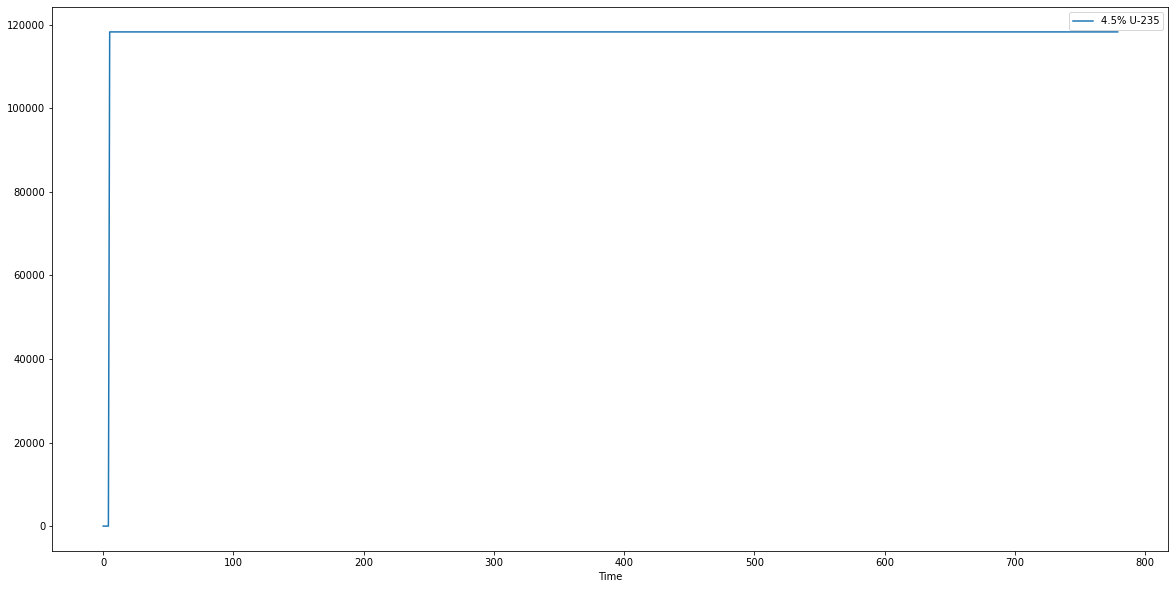

In [6]:
enriched_u[['Time','enr_u']].plot(x='Time', legend=False, figsize=(20,10))
legend = plt.legend()
legend.get_texts()[0].set_text('4.5% U-235')
plt.show()

In [7]:
# kgs of enriched U required in a year
Product_mass = enriched_u['enr_u'][24:36].sum()

1419084.346882292

## Determining feed, tails, and product assay

In [23]:
import xml.etree.ElementTree as ET 

In [83]:
root = ET.parse('../inputs/united_states/recipes/uox_51.xml').getroot()
recipes = root.findall('./')

for item in recipes:
    for child in item:
        if child.text == 'enr_u':
            enrichment_recipe = item
        if child.text == 'nat_u':
            naturalu_recipe = item
for item in enrichment_recipe:
    for child in item:
        if child.text == '922350000':
            print(child.attrib)

{}


In [ ]:
#Defining assays
x_p = 0.045
x_f = 0.00711
x_t = 0.002

## SWU Calculation
SWU = (P*V(x_p) + T*V(x_t) - F*V(x_f))*t

V(x_i) = (2*x_i-1)*ln(x_i/(1-x_i))

In [9]:
def separation_potential(x_i):
    '''
    Calculates Separation Potentail, for use in calculating 
    Separative Work Units (SWU) required for enrichment level
    
    Inputs:
    -------
    x_i: int
        mass fraction of mass stream
    
    Returns:
    --------
    v: int
        Separation potential
    '''
    v = (2*x_i - 1) * np.log(x_i/(1-x_i))
    
def SWU()